In [ ]:
!pip install transformers



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import transformers
from wordcloud import WordCloud
import os
import re
from nltk.corpus import stopwords
from nltk.stem.porter import *
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_dataset(folder):
    RawData = []
    for group in ["pos", "neg"]:
        for filename in os.listdir(os.path.join(folder, group)):
            with open(os.path.join(folder, group, filename), "r", encoding="utf-8") as f:
                txt = f.read()
                RawData.append({"Review": txt, "Category": 1 if group=="pos" else 0})
    return pd.DataFrame(RawData)
Train_Dataset = load_dataset("/content/drive/My Drive/Movie/aclImdb/train")
Test_Dataset = load_dataset("/content/drive/My Drive/Movie/aclImdb/test")
Total_Dataset = pd.concat([Train_Dataset, Test_Dataset], axis=0)
Total_Dataset = Total_Dataset.sample(frac=1)

# **BERT Grid Search**

In [ ]:
# Import required libraries
import random
import numpy as np
import torch
import transformers
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )
print(device)
# Set random seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Load the IMDB data
from sklearn.datasets import load_files
imdb_data =Total_Dataset# load_files("aclImdb/train/", shuffle=True)
#XX = imdb_data['Review'].values.tolist()
#YY = np.array(imdb_data.Category)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(imdb_data['Review'].values.tolist(), np.array(imdb_data.Category), random_state=seed_val, test_size=0.8)

# Tokenize input text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']).to(device),
                              torch.tensor(train_encodings['attention_mask']).to(device),
                              torch.tensor(train_labels).to(device))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']).to(device),
                            torch.tensor(val_encodings['attention_mask']).to(device),
                            torch.tensor(val_labels).to(device))

# Set up training parameters
batch_size = 8
Epochs = 4
learning_rate = 2e-5

# Set up data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the Bert model and optimizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

# Define training function
def BERT_MODEL(model, optimizer, train_loader,val_loader,Epoches):
  avg_accuracy_tr = []
  avg_accuracy_t = []
  for epochs in range(Epoches):
    print('Epoch number : {}'.format(epochs))
    total_loss_tr, total_accuracy_tr = 0, 0
    total_preds_tr = []
    total_loss_t, total_accuracy_t = 0, 0
    total_preds_t = []
    #train Model
    model.train()
    for step, batch in enumerate(train_loader):
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
      optimizer.zero_grad()

      outputs = model(**inputs)

      loss = outputs[0]
      logits = outputs[1]
      total_loss_tr += loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      preds = torch.argmax(logits, dim=1).flatten()
      total_preds_tr += preds.tolist()
      labels = inputs['labels'].flatten()
      total_accuracy_tr += accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())

    avg_loss = total_loss_tr / len(train_loader)
    avg_accuracy_tr.append(total_accuracy_tr / len(train_loader))

    # Evaluate Model
    model.eval()
    for step, batch in enumerate(val_loader):
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
      with torch.no_grad():
        outputs = model(**inputs)

      loss = outputs[0]
      logits = outputs[1]
      total_loss_t += loss.item()

      preds = torch.argmax(logits, dim=1).flatten()
      total_preds_t += preds.tolist()
      labels = inputs['labels'].flatten()
      total_accuracy_t += accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
    avg_accuracy_t.append(total_accuracy_t/ len(val_loader))

  return  avg_accuracy_tr,avg_accuracy_t

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  128 , Batch Size = 4 , Learning Rate = 1e-05   is  0.8764 
 Test Accuracy For Max Length =  128 , Batch Size = 4 , Learning Rate = 2e-05   is  0.8824 
 Test Accuracy For Max Length =  128 , Batch Size = 4 , Learning Rate = 5e-05   is  0.5049 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  128 , Batch Size = 8 , Learning Rate = 1e-05   is  0.8921 
 Test Accuracy For Max Length =  128 , Batch Size = 8 , Learning Rate = 2e-05   is  0.8817 
 Test Accuracy For Max Length =  128 , Batch Size = 8 , Learning Rate = 5e-05   is  0.8728 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  128 , Batch Size = 16 , Learning Rate = 1e-05   is  0.8874 
 Test Accuracy For Max Length =  128 , Batch Size = 16 , Learning Rate = 2e-05   is  0.8835 
 Test Accuracy For Max Length =  128 , Batch Size = 16 , Learning Rate = 5e-05   is  0.8877 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  128 , Batch Size = 32 , Learning Rate = 1e-05   is  0.8615215654952076 
 Test Accuracy For Max Length =  128 , Batch Size = 32 , Learning Rate = 2e-05   is  0.8986621405750799 
 Test Accuracy For Max Length =  128 , Batch Size = 32 , Learning Rate = 5e-05   is  0.8750998402555911 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  256 , Batch Size = 4 , Learning Rate = 1e-05   is  0.9079 
 Test Accuracy For Max Length =  256 , Batch Size = 4 , Learning Rate = 2e-05   is  0.9113 
 Test Accuracy For Max Length =  256 , Batch Size = 4 , Learning Rate = 5e-05   is  0.8641 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  256 , Batch Size = 8 , Learning Rate = 1e-05   is  0.9187 
 Test Accuracy For Max Length =  256 , Batch Size = 8 , Learning Rate = 2e-05   is  0.9204 
 Test Accuracy For Max Length =  256 , Batch Size = 8 , Learning Rate = 5e-05   is  0.8856 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  256 , Batch Size = 16 , Learning Rate = 1e-05   is  0.9185 
 Test Accuracy For Max Length =  256 , Batch Size = 16 , Learning Rate = 2e-05   is  0.9181 
 Test Accuracy For Max Length =  256 , Batch Size = 16 , Learning Rate = 5e-05   is  0.9055 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  256 , Batch Size = 32 , Learning Rate = 1e-05   is  0.9128394568690096 
 Test Accuracy For Max Length =  256 , Batch Size = 32 , Learning Rate = 2e-05   is  0.9235223642172524 
 Test Accuracy For Max Length =  256 , Batch Size = 32 , Learning Rate = 5e-05   is  0.9170327476038339 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  512 , Batch Size = 4 , Learning Rate = 1e-05   is  0.9243 
 Test Accuracy For Max Length =  512 , Batch Size = 4 , Learning Rate = 2e-05   is  0.9254 
 Test Accuracy For Max Length =  512 , Batch Size = 4 , Learning Rate = 5e-05   is  0.5049 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  512 , Batch Size = 8 , Learning Rate = 1e-05   is  0.9226 
 Test Accuracy For Max Length =  512 , Batch Size = 8 , Learning Rate = 2e-05   is  0.9289 
 Test Accuracy For Max Length =  512 , Batch Size = 8 , Learning Rate = 5e-05   is  0.9118 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  512 , Batch Size = 16 , Learning Rate = 1e-05   is  0.9235 
 Test Accuracy For Max Length =  512 , Batch Size = 16 , Learning Rate = 2e-05   is  0.9285 
 Test Accuracy For Max Length =  512 , Batch Size = 16 , Learning Rate = 5e-05   is  0.9263 


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

 Test Accuracy For Max Length =  512 , Batch Size = 32 , Learning Rate = 1e-05   is  0.9253194888178914 
 Test Accuracy For Max Length =  512 , Batch Size = 32 , Learning Rate = 2e-05   is  0.9300119808306709 
 Test Accuracy For Max Length =  512 , Batch Size = 32 , Learning Rate = 5e-05   is  0.9306110223642172 


# **BERT Model with Plot**

In [ ]:
# Import required libraries
import random
import numpy as np
import torch
import transformers
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )
print(device)
# Set random seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Load the IMDB data
from sklearn.datasets import load_files
imdb_data =Total_Dataset# load_files("aclImdb/train/", shuffle=True)
#XX = imdb_data['Review'].values.tolist()
#YY = np.array(imdb_data.Category)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(imdb_data['Review'].values.tolist(), np.array(imdb_data.Category), random_state=seed_val, test_size=0.8)

# Tokenize input text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']).to(device),
                              torch.tensor(train_encodings['attention_mask']).to(device),
                              torch.tensor(train_labels).to(device))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']).to(device),
                            torch.tensor(val_encodings['attention_mask']).to(device),
                            torch.tensor(val_labels).to(device))

# Set up training parameters
batch_size = 32
Epochs = 4
learning_rate = 2e-5

# Set up data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the Bert model and optimizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

# Define training function
def BERT_MODEL(model, optimizer, train_loader,val_loader,Epoches):
  avg_accuracy_tr = []
  avg_accuracy_t = []
  for epochs in range(Epoches):
    print('Epoch number : {}'.format(epochs+1))
    total_loss_tr, total_accuracy_tr = 0, 0
    total_preds_tr = []
    total_loss_t, total_accuracy_t = 0, 0
    total_preds_t = []
    #train Model
    model.train()
    for step, batch in enumerate(train_loader):
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
      optimizer.zero_grad()

      outputs = model(**inputs)

      loss = outputs[0]
      logits = outputs[1]
      total_loss_tr += loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      preds = torch.argmax(logits, dim=1).flatten()
      total_preds_tr += preds.tolist()
      labels = inputs['labels'].flatten()
      total_accuracy_tr += accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())

    avg_loss = total_loss_tr / len(train_loader)
    avg_accuracy_tr.append(total_accuracy_tr / len(train_loader))

    # Evaluate Model
    model.eval()
    for step, batch in enumerate(val_loader):
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
      with torch.no_grad():
        outputs = model(**inputs)

      loss = outputs[0]
      logits = outputs[1]
      total_loss_t += loss.item()

      preds = torch.argmax(logits, dim=1).flatten()
      total_preds_t += preds.tolist()
      labels = inputs['labels'].flatten()
      total_accuracy_t += accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
    avg_accuracy_t.append(total_accuracy_t/ len(val_loader))

  return  avg_accuracy_tr,avg_accuracy_t

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
accu_train,accu_test = BERT_MODEL(model, optimizer, train_loader,val_loader,Epochs)

Epoch number : 1
Epoch number : 2
Epoch number : 3
Epoch number : 4


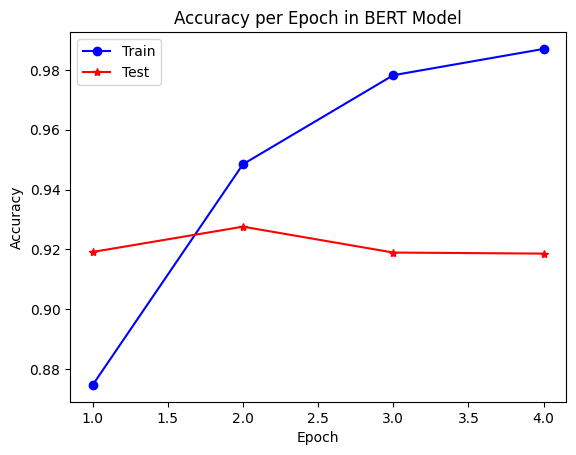

In [ ]:
#80/20
import matplotlib.pyplot as plt

x = [1, 2, 3, 4]

# Plot the two lines
plt.plot(x, accu_train, '-o', color='blue', label='Train')
plt.plot(x, accu_test, '-*', color='red', label='Test')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch in BERT Model')
plt.legend()

# Display the plot
plt.show()

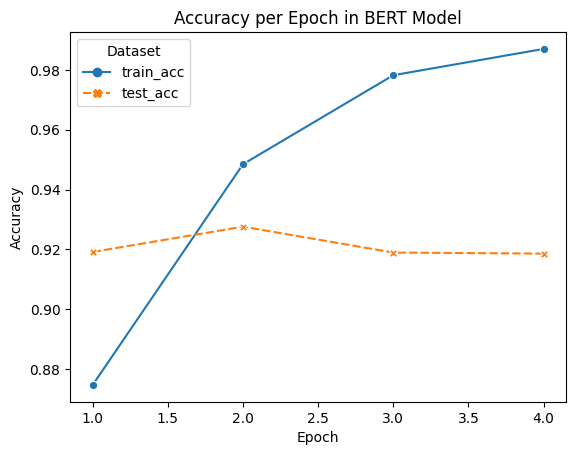

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a Pandas DataFrame with the data
data = pd.DataFrame({
    'epoch': [1, 2, 3, 4],
    'train_acc': accu_train,
    'test_acc': accu_test
})

# Melt the DataFrame to create a long-form version
data_melt = pd.melt(data, id_vars=['epoch'], var_name='dataset', value_name='accuracy')

# Plot the data using Seaborn
sns.lineplot(x='epoch', y='accuracy', hue='dataset', style='dataset', markers=True, data=data_melt)

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch in BERT Model')
plt.legend(title='Dataset')

# Display the plot
plt.show()